In [1]:
import pandas as pd
import math
import copy
import numpy as np 
import itertools
import more_itertools as mit
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
import string
import re

In [2]:
# load some queries for testing
queries_text = pd.read_csv('nfcorpus/dev.all.queries', sep='\t', names=['ID', 'TEXT'])
queries_text.head(10)

ID                                               TEXT
0     PLAIN-1  why deep fried foods may cause cancer in the l...
1  PLAIN-1007  ddt - - persistent organic pollutants , indust...
2   PLAIN-101  how to treat multiple sclerosis with diet mult...
3  PLAIN-1017  detoxification - - cancer , raw food , heart h...
4  PLAIN-1027  dietary guidelines - - heart disease , cardiov...
5  PLAIN-1038  dogs - - meat , animal products , cats , heart...
6  PLAIN-1049  dr. david spence - - heart health , heart dise...
7  PLAIN-1065  dr. walter kempner - - mortality , heart disea...
8  PLAIN-1077  dulse - - thyroid health , hijiki , sushi , io...
9  PLAIN-1087  easter island - - mortality , muscle strength ...

## Corpus Preprocessing

In [3]:
def preprocess_corpus(data):
    
    ps = PorterStemmer()
    
    def stemSentence(sentence,ps):
        token_words = word_tokenize(sentence)
        stem_sentence = []
        for word in token_words:
            stem_sentence.append(ps.stem(word))
            stem_sentence.append(" ")
        return "".join(stem_sentence)
    
    data['TEXT'] = data.apply(lambda x: stemSentence(x['TEXT'],ps), axis=1)
    
    return data

In [4]:
# load corpus as preprocessed set of documents
corpus = pd.read_csv('nfcorpus/dev.docs', sep='\t', names=['ID', 'TEXT'])

# corpus preprocessing
corpus = preprocess_corpus(corpus)
# preview first rows
corpus.head()

ID                                               TEXT
0  MED-118  alkylphenol human milk relat dietari habit cen...
1  MED-329  phosphat vascular toxin pubm ncbi abstract ele...
2  MED-330  dietari phosphoru acut impair endotheli functi...
3  MED-332  public health impact dietari phosphoru excess ...
4  MED-334  differ total vitro digest phosphoru content pl...

 ## Query Preprocessing

In [88]:
def preprocess_queries(corpus, queries):
    
    def remove_punctuations(text): # remove punctuation
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
        return text

    def remove_numbers(text): # remove numbers
        return re.sub('[0-9]+', '', text)
    
    def lower_case(text): # lower case
        text = text.lower()
        return text 
    
    def tokenize(text): #tokenize
        return word_tokenize(text)
    
    stop = set(stopwords.words('english'))   
    def stop_words(tokens): # stop words 
        filtered_words = []
        for word in tokens:
            if word not in stop:
                filtered_words.append(word)
        return filtered_words
    
    ps = PorterStemmer()
    def stemming(tokens, ps): # stemming
        return [ps.stem(w) for w in tokens] 
    
    def corpus_vocab(corpus):
        vocab = []
        corpus_tokens = corpus.apply(lambda x: word_tokenize(x['TEXT']), axis=1)
        for i, j in corpus_tokens.iteritems():
            for token in j:
                if token not in vocab:
                    vocab.append(token)        
        return vocab
    
    v = corpus_vocab(corpus)    
    def filter_query(tokens):
        t = []
        for token in tokens:
            if token in v:
                t.append(token)
        return t
    def create_string(tokens):
        s = []
        for token in tokens:
            s.append(token)
            s.append(" ")
        return "".join(s)
        
    # apply functions
    queries['TEXT'] = queries.apply(lambda x: remove_punctuations(x['TEXT']), axis=1)
    queries['TEXT'] = queries.apply(lambda x: remove_numbers(x['TEXT']), axis=1)
    queries['TEXT'] = queries.apply(lambda x: lower_case(x['TEXT']), axis=1)
    queries['TEXT'] = queries.apply(lambda x: tokenize(x['TEXT']), axis=1)
    queries['TEXT'] = queries.apply(lambda x: stop_words(x['TEXT']), axis=1)
    queries['TEXT'] = queries.apply(lambda x: stemming(x['TEXT'],ps), axis=1)
    queries['TEXT'] = queries.apply(lambda x: filter_query(x['TEXT']), axis=1)
    queries['TEXT'] = queries.apply(lambda x: create_string(x['TEXT']), axis=1)
    
    return queries

In [89]:
# load some queries for testing
queries_text = pd.read_csv('nfcorpus/dev.all.queries', sep='\t', names=['ID', 'TEXT'])

queries_text = preprocess_queries(corpus, queries_text)
queries_text.head(10)

ID                                               TEXT
0     PLAIN-1  deep fri food may caus cancer latest studi die...
1  PLAIN-1007  ddt persist organ pollut industri toxin pestic...
2   PLAIN-101  treat multipl sclerosi diet multipl sclerosi u...
3  PLAIN-1017  detoxif cancer raw food heart health heart dis...
4  PLAIN-1027  dietari guidelin heart diseas cardiovascular d...
5  PLAIN-1038  dog meat anim product cat heart health tobacco...
6  PLAIN-1049  dr heart health heart diseas egg cholesterol s...
7  PLAIN-1065  dr walter mortal heart diseas heart health die...
8  PLAIN-1077  thyroid health hijiki sushi iodin sea veget sa...
9  PLAIN-1087  easter island mortal muscl strength morbid moo...

## Term frequency

In [7]:
# Term frequency
def tf(corpus, column_name):
    
    def tokenize(string):
        return string.split()
    
    def tf_string(string): 
        # create bag of words from the string
        bow = tokenize(string)
    
        tf_dict = {}
        for word in bow:
            if word in tf_dict:
                tf_dict[word] += 1
            else:
                tf_dict[word] = 1
            
        for word in tf_dict:
            tf_dict[word] =  1 + math.log(tf_dict[word])
    
        return tf_dict
    
    # call our function on every doc and store all these tf dictionaries. 
    tf_dict = {}
    for index, row in corpus.iterrows():
        doc_dict = tf_string(row[column_name])
        tf_dict[index] = doc_dict
            
    return tf_dict

# Inversed document frequency

In [8]:
# Inversed document frequency
def idf(corpus, tf_dict):
    
    # nomber of documents in corpus
    no_of_docs = len(corpus.index)
    
    # term - key, number of docs term occured in
    def count_occurances(tf_dict):
        count_dict = {}
        for key in tf_dict:
            for key in tf_dict[key]:
                if key in count_dict:
                    count_dict[key] += 1
                else:
                    count_dict[key] = 1
        return count_dict

    idf_dict = {}
    
    count_dict = count_occurances(tf_dict)
    
    for key in count_dict:
        idf_dict[key] = math.log(no_of_docs/count_dict[key])
    
    return idf_dict

## TF-IDF

In [9]:
# TF-IDF
def tf_idf(tf_dict, idf_dict):   
    tf_idf_dict = copy.deepcopy(tf_dict)
    for doc, value in tf_idf_dict.items():
        for word, value in tf_idf_dict[doc].items():
            tf_idf_dict[doc][word] = value * idf_dict[word]
    return tf_idf_dict

# Cousine similarity

In [10]:
# Convert tf_idf_dict to matrix
def tf_idf_to_matrix(tf_idf_dict):
    tf_idf_matrix = pd.DataFrame.from_dict(tf_idf_dict, 
                                           orient = 'index').fillna(0) # if word does not appear in doc we change NaN to
    return tf_idf_matrix.sort_index()

In [11]:
#create TF-IDF matrix
tf_dict = tf(corpus, column_name = 'TEXT')
idf_dict = idf(corpus, tf_dict)
tf_idf_dict = tf_idf(tf_dict, idf_dict)
tf_idf_matrix = tf_idf_to_matrix(tf_idf_dict)
tf_idf_matrix.head()

alkylphenol     human      milk    relat   dietari     habit   central  \
0     6.122806  2.886416  6.547579  2.90854  2.095849  5.898499  3.473596   
1     0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000  0.00000  2.597750  0.000000  0.000000   
3     0.000000  0.000000  0.000000  0.00000  2.597750  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   

     taiwan      pubm     ncbi  ...  six-year  inchianti  tuscani  \
0  5.503767  0.266507  0.27307  ...       0.0        0.0      0.0   
1  0.000000  0.266507  0.27307  ...       0.0        0.0      0.0   
2  0.000000  0.000000  0.00000  ...       0.0        0.0      0.0   
3  0.000000  0.266507  0.27307  ...       0.0        0.0      0.0   
4  0.000000  0.266507  0.27307  ...       0.0        0.0      0.0   

   studies-depress  eurosav  self-inflict  eurostat  suicide-record  scarciti  \
0              0.0      0.0           0.0       0.0             0.0       0.0   
1              0.0      0.0           0.0       0.0             0.0       0.0   
2              0.0      0.0           0.0       0.0             0.0       0.0   
3              0.0      0.0           0.0       0.0             0.0       0.0   
4              0.0      0.0           0.0       0.0             0.0       0.0   

   trim-and-fil  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 19930 columns]

In [42]:
tf_idf_matrix.shape

(3193, 19930)

In [12]:
# Cosine similarity
def cosine_similarity(v1, v2):
    
    def vector_magnitude(v):
        return np.linalg.norm(v)
    
    def dot_product(v1, v2):
        return np.dot(v1,v2)
    
    return dot_product(v1, v2)/ (vector_magnitude(v1) * vector_magnitude(v2))

# Random projections

In [13]:
def norm(vectors):
    norm_vectors = []
    if len(vectors) == 1:
        norm_vectors.append(vectors/np.linalg.norm(vectors))
    else:
        for vec in vectors:
            norm_vectors.append(vec/np.linalg.norm(vec))
    return np.array(norm_vectors)

def get_random_vectors(dim,m):
    vectors = np.random.random((m, dim))
    return norm(vectors)

def compute_hash(docs, rnd_vec, t):
    hashed_doc_vectors = []
    #for each document in document collection
    for doc in docs:
        hashed_dot_product = []
        inner_product = doc.dot(rnd_vec.transpose())
        for i in inner_product:  
            if i>t:
                hashed_dot_product.append(1)
            else:
                hashed_dot_product.append(0)
        hashed_doc_vectors.append(hashed_dot_product)
    return np.array(hashed_doc_vectors)

In [14]:
#create normalized random vectors
np.random.seed(0)
vocab_size = len(tf_idf_matrix.columns)
random_vectors = get_random_vectors(vocab_size, m = 1000)

print('dimension of the set of random vectors: ', random_vectors.shape)
print(random_vectors[1])
print(np.linalg.norm(random_vectors[1]))


dimension of the set of random vectors:  (1000, 19930)
[0.00509512 0.00581969 0.00195364 ... 0.00109644 0.00322468 0.00769748]
1.0


In [15]:
#normalize document vectors
doc_vectors = tf_idf_matrix.values
norm_doc_vectors = norm(doc_vectors)

print(norm_doc_vectors[0])
print(np.linalg.norm(norm_doc_vectors[0]))

[0.166669   0.07857116 0.17823174 ... 0.         0.         0.        ]
0.9999999999999999


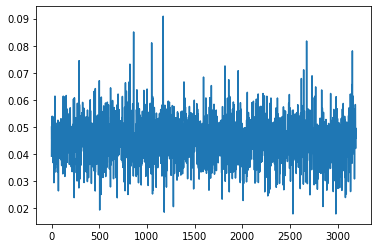

In [16]:
import matplotlib.pyplot as plt
#### test compute_hash
m=[]
for i in range(3193):
    inn = norm_doc_vectors[i].dot(random_vectors.transpose())
    m.append(np.mean(inn))

plt.plot(range(3193),m)
plt.show()

In [17]:
print(np.mean(m))

0.045068840456878735


In [16]:
#compute new document vectors with reduced dimensionality
doc_projections = compute_hash(norm_doc_vectors, random_vectors, 0.045)
doc_projections[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

# Evaluate random projections on query

In [90]:
def vectorize_query(textstring):
    if type(textstring) == str:
        tokenized_query = textstring.split()
    else:
        tokenized_query = textstring
        
    df_query = tf_idf_matrix[0:0] #dataframe of tf-idf weights of a query
    df_query = df_query.append(pd.Series(0, index=df_query.columns), ignore_index=True)
    for token in tokenized_query:
        for col in df_query.columns:
            if token == col:
                df_query[col][0] = df_query[col][0] + 1 #raw term frequency
    
    df_query = df_query.replace(0, np.nan)
    
    df_query = np.log(df_query) + 1 #log term freq(as in the slides)
    
    df_query = df_query.fillna(0)
    
    for col in df_query.columns:
        df_query[col][0] = df_query[col][0] * idf_dict[col]
        
    return df_query

In [91]:
query = queries_text['TEXT'][0]
query_vector = norm(vectorize_query(query).values)
print(query_vector.size)
#plt.plot(range(19930),query_vector[0][0])
#plt.show()

19930


In [92]:
#retrieve k documents with highest cousine similarity between projected query and doc vectors
def retrieve_with_random_projections(string_query, docs, k=10):
    df = corpus.copy()
    #tranform into a vector
    query_vector = norm(vectorize_query(string_query).values)
    hashed_query = compute_hash(query_vector[0], random_vectors, 0.045)
    sim = [] # to store cosine similarities
    sort_sim =[] #sorted cosine similarities
    i=0
    for doc in docs:
        sim.append([i,cosine_similarity(hashed_query,doc)])
        i+=1
    sort_sim = sorted(sim, key = lambda cos: cos[1], reverse=True)
    ids = []
    
    for j in range(k):
        ids.append(sort_sim[j][0])
        
    return df.iloc[ids]

query=queries_text['TEXT'][0]
retrieve_with_random_projections(query, doc_projections)


C:\Users\linar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\linar\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


ID                                               TEXT
196   MED-1236  pathogenesi type num diabet trace revers rout ...
406   MED-1501  systemat review factor risk prevent cognit dec...
446   MED-1554  reduc modifi dietari fat prevent cardiovascula...
597   MED-1739  roundup disrupt male reproduct function trigge...
796   MED-2010  nutrit qualiti legum role cardiometabol risk p...
1594  MED-3177  neurocysticercosi enigmat diseas pubm ncbi abs...
401   MED-1496  brain rust recent discoveri role oxid stress n...
3      MED-332  public health impact dietari phosphoru excess ...
409   MED-1504  risk factor prevent intervent alzheim diseas s...
18     MED-714  prevent vitamin defici knowledg gap research v...

In [93]:
#upload the query relevance
queries_relevance = pd.read_csv('nfcorpus/dev.2-1-0.qrel', sep='\t', names=['QUERY_ID', '0', 'DOC_ID', 'RELEVANCE_LEVEL'])
queries_relevance.head(10)

QUERY_ID  0    DOC_ID  RELEVANCE_LEVEL
0  PLAIN-1  0  MED-2421                2
1  PLAIN-1  0  MED-2422                2
2  PLAIN-1  0  MED-2416                2
3  PLAIN-1  0  MED-2423                2
4  PLAIN-1  0  MED-2417                2
5  PLAIN-1  0  MED-2418                2
6  PLAIN-1  0  MED-4451                2
7  PLAIN-1  0  MED-2420                2
8  PLAIN-1  0  MED-2414                1
9  PLAIN-1  0  MED-4070                1

In [94]:

def true_relevant_docs(string_query):
    query_row = (queries_text.loc[queries_text['TEXT'].isin([string_query])])
    query_id = query_row.iloc[0]["ID"]
    relevance_lvl = [1, 2]
    return queries_relevance.loc[queries_relevance['QUERY_ID'].isin([query_id]) & queries_relevance['RELEVANCE_LEVEL'].isin(relevance_lvl)]

In [95]:
true_relevant_docs(queries_text['TEXT'][0])

QUERY_ID  0    DOC_ID  RELEVANCE_LEVEL
0   PLAIN-1  0  MED-2421                2
1   PLAIN-1  0  MED-2422                2
2   PLAIN-1  0  MED-2416                2
3   PLAIN-1  0  MED-2423                2
4   PLAIN-1  0  MED-2417                2
5   PLAIN-1  0  MED-2418                2
6   PLAIN-1  0  MED-4451                2
7   PLAIN-1  0  MED-2420                2
8   PLAIN-1  0  MED-2414                1
9   PLAIN-1  0  MED-4070                1
10  PLAIN-1  0  MED-3498                1
11  PLAIN-1  0  MED-2424                1
12  PLAIN-1  0  MED-2426                1
13  PLAIN-1  0  MED-2674                1
14  PLAIN-1  0  MED-2675                1
15  PLAIN-1  0  MED-2676                1
16  PLAIN-1  0  MED-2677                1
17  PLAIN-1  0  MED-2678                1
18  PLAIN-1  0  MED-2679                1
19  PLAIN-1  0  MED-4037                1
20  PLAIN-1  0  MED-4038                1
21  PLAIN-1  0  MED-4976                1
22  PLAIN-1  0  MED-4450                1
23  PLAIN-1  0  MED-5085                1
24  PLAIN-1  0  MED-5086                1
25  PLAIN-1  0  MED-5087                1
26  PLAIN-1  0  MED-5088                1
27  PLAIN-1  0  MED-5089                1
28  PLAIN-1  0  MED-5322                1
29  PLAIN-1  0  MED-5323                1
30  PLAIN-1  0  MED-5324                1
31  PLAIN-1  0  MED-5325                1
32  PLAIN-1  0  MED-5326                1
33  PLAIN-1  0  MED-5327                1
34  PLAIN-1  0  MED-5328                1
35  PLAIN-1  0  MED-5329                1
36  PLAIN-1  0  MED-5330                1
37  PLAIN-1  0  MED-5331                1
38  PLAIN-1  0  MED-5332                1
39  PLAIN-1  0  MED-5333                1
40  PLAIN-1  0  MED-5334                1
41  PLAIN-1  0  MED-5335                1
42  PLAIN-1  0  MED-5363                1
43  PLAIN-1  0  MED-5337                1
44  PLAIN-1  0  MED-5338                1
45  PLAIN-1  0  MED-5339                1
46  PLAIN-1  0  MED-5340                1
47  PLAIN-1  0  MED-5341                1
48  PLAIN-1  0  MED-5342                1

In [96]:
def apk(actual, predicted):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), len(predicted))

def mapk(actual, predicted, k=5):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [97]:
def dcg(element_list):
    """
    Discounted Cumulative Gain (DCG)
    Parameters:
        element_list - a list of ranks Ex: [5,4,2,2,1]
    Returns:
        score
    """
    score = 0.0
    for order, rank in enumerate(element_list):
        score += float(rank)/math.log((order+2))
    return score


def ndcg(reference, hypothesis):
    """
    Normalized Discounted Cumulative Gain (nDCG)
    Normalized version of DCG:
        nDCG = DCG(hypothesis)/DCG(reference)
    Parameters:
        reference   - a gold standard (perfect) ordering Ex: [5,4,3,2,1]
        hypothesis  - a proposed ordering Ex: [5,2,2,3,1]
    Returns:
        ndcg_score  - normalized score
    """
    if dcg(reference) == 0:
        return 0 
    else:
        return dcg(hypothesis)/dcg(reference)

In [98]:
def evaluate_retrieve_with_random_projections(query_text, docs,k=10):
    ## returns the triple (Precision, Average Precision, Normalized Discounted Cumulative Gain)
    relevant = true_relevant_docs(query_text)
    retrieved_df = retrieve_with_random_projections(query_text,docs,k=10)
    ids_retrieved = []
    for i in range(len(retrieved_df)):
        ids_retrieved.append(retrieved_df.iloc[i].ID)
    ids_retrieved.sort()
    
    
    ids_true_relevant = []
    for i in range(len(relevant)):
        ids_true_relevant.append(relevant.iloc[i].DOC_ID)
    ids_true_relevant.sort()
    
    #count true positives and false positives
    tp = 0
    fp = 0
    for i in ids_retrieved:
        for j in ids_true_relevant:
            if i == j:
                tp += 1 
                break
            else:
                if i < j:
                    fp += 1 
                    break
                else:
                    continue
    if (tp == 0) & (fp == 0):
        precision = 0
    else:
        precision = tp/(tp+fp)
    #cannot calculate recall, since we predefined the number of retrieved documents => apriori algorithm cannot retrieve all documents
    
    #then calculate Average precision across retrieved documents
    ap = apk(ids_true_relevant, ids_retrieved)
    
    #since we have graded relevance annotations, we can also calculate Normalized Discounted Cumulative Gain
    list_of_ranks_of_retrieved_docs = []
    for i in ids_retrieved:
        if i in ids_true_relevant:
            list_of_ranks_of_retrieved_docs.append(relevant.loc[relevant['DOC_ID'].isin([i])].RELEVANCE_LEVEL.iloc[0])
        else:
            list_of_ranks_of_retrieved_docs.append(0)

                                               
    list_of_ranks_of_relevant_docs = []
    for i in ids_true_relevant:
        list_of_ranks_of_relevant_docs.append(relevant.loc[relevant['DOC_ID'].isin([i])].RELEVANCE_LEVEL.iloc[0])
    list_of_ranks_of_relevant_docs.sort(reverse = True)
    
    k=len(list_of_ranks_of_retrieved_docs)
    list_of_ranks_of_relevant_docs = list_of_ranks_of_relevant_docs[:k]
        
    return precision, ap, ndcg(list_of_ranks_of_relevant_docs, list_of_ranks_of_retrieved_docs)

In [99]:

def evaluate_random_projections(k=10):
    evaluation = queries_text.copy()
    evaluation.insert(2, "Precision", 0)
    evaluation.insert(3, "Average Precision", 0)
    evaluation.insert(4, "nDCG", 0)
    
    for i in range(len(evaluation)):

        p, a, n = evaluate_retrieve_with_random_projections(queries_text.loc[i, 'TEXT'], doc_projections,k=10)
        evaluation.loc[i, 'Precision'] = p
        evaluation.loc[i, 'Average Precision'] = a
        evaluation.loc[i, 'nDCG'] = n
    
    print('Average precision across all queries = ' + str(evaluation['Precision'].mean()))
    print('Mean Average Precision = ' + str(evaluation['Average Precision'].mean()))
    print('Average nDCG = ' + str(evaluation['nDCG'].mean()))
    
    return evaluation

In [101]:
rand_proj_evaluation = evaluate_random_projections(k=10)

C:\Users\linar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\linar\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


Average precision across all queries = 0.008735042735042735
Mean Average Precision = 0.001925030525030525
Average nDCG = 0.0055070577679929905


In [102]:
rand_proj_evaluation.head()

ID                                               TEXT  Precision  \
0     PLAIN-1  deep fri food may caus cancer latest studi die...        0.0   
1  PLAIN-1007  ddt persist organ pollut industri toxin pestic...        0.0   
2   PLAIN-101  treat multipl sclerosi diet multipl sclerosi u...        0.0   
3  PLAIN-1017  detoxif cancer raw food heart health heart dis...        0.0   
4  PLAIN-1027  dietari guidelin heart diseas cardiovascular d...        0.0   

   Average Precision  nDCG  
0                0.0   0.0  
1                0.0   0.0  
2                0.0   0.0  
3                0.0   0.0  
4                0.0   0.0